### Load Data

In [1]:
with open('macmorpho-v3/macmorpho-test.txt', 'r') as f:
    lines = f.readlines()


sentences = []
true_tags = []
for line in lines:
    word_tag_pairs = line.strip().split()
    sentence = " ".join(word.split('_')[0] for word in word_tag_pairs)
    sentences.append(sentence)
    true_tags.append([word.split('_')[1] for word in word_tag_pairs])

### Data Analysis

#### Co-occurrence matrix

In [2]:
import itertools
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#co-occurrences of tag pairs
tag_pairs_count = Counter()
for tags in true_tags:
    for tag1, tag2 in itertools.combinations(tags, 2):
        if tag1 != tag2:
            tag_pairs_count[(tag1, tag2)] += 1
            tag_pairs_count[(tag2, tag1)] += 1

In [3]:
unique_tags = sorted(set(itertools.chain.from_iterable(true_tags)))
cooc_matrix = pd.DataFrame(index=unique_tags, columns=unique_tags, data=0)

for (tag1, tag2), count in tag_pairs_count.items():
    cooc_matrix.at[tag1, tag2] = count


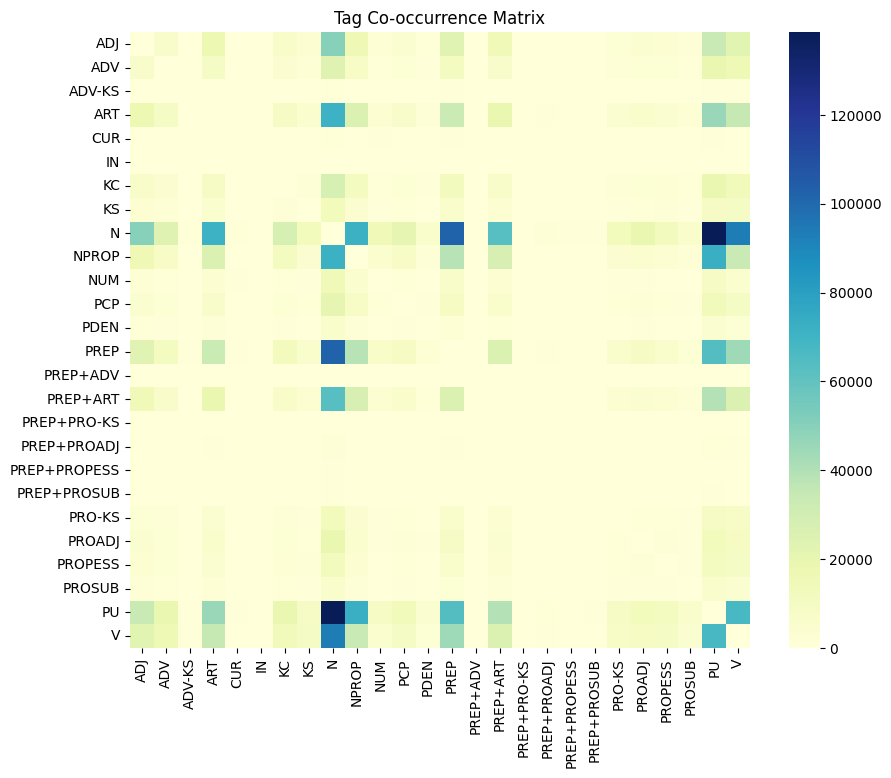

In [4]:
plt.figure(figsize=(10, 8))
sns.heatmap(cooc_matrix, annot=False, cmap="YlGnBu")
plt.title("Tag Co-occurrence Matrix")
plt.show()

#### Tags Distribution

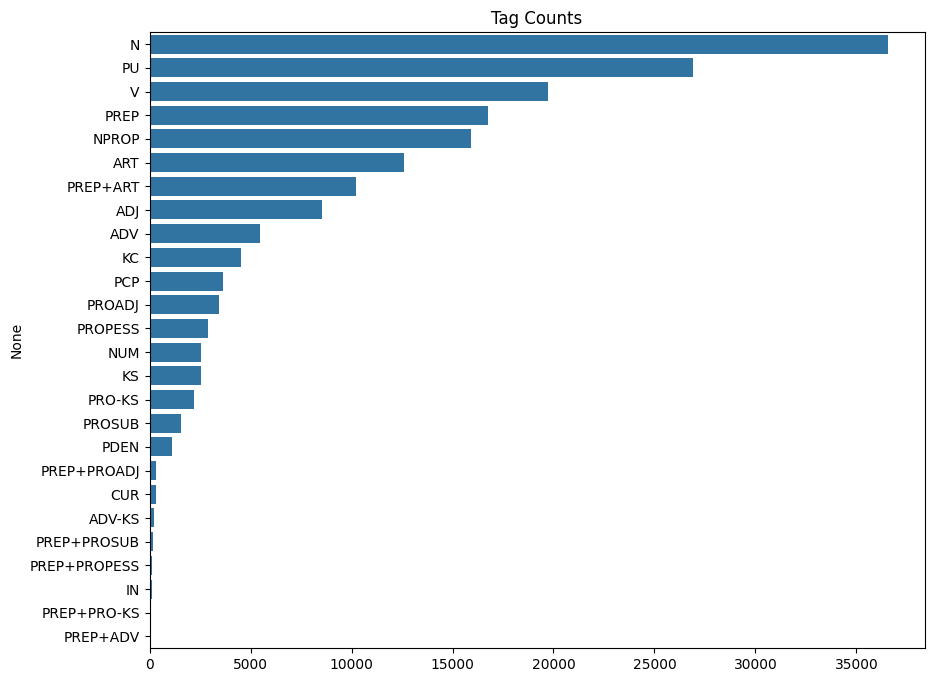

In [5]:

tag_counts = Counter(itertools.chain.from_iterable(true_tags))
tag_counts = pd.Series(tag_counts).sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=tag_counts.values, y=tag_counts.index)
plt.title("Tag Counts")
plt.show()


### Load Model (bertimbau)

In [7]:
from transformers import AutoTokenizer, AutoModelForTokenClassification


# Carregar modelo e tokenizador
tokenizer = AutoTokenizer.from_pretrained("lisaterumi/postagger-portuguese")
model = AutoModelForTokenClassification.from_pretrained("lisaterumi/postagger-portuguese")

# Função para prever as tags
def predict_tags(sentence):
    # Tokenização
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)
    
    # Predição
    with torch.no_grad():
        outputs = model(**inputs)

    # Obter o ID da tag mais provável
    predictions = torch.argmax(outputs.logits, dim=2)

    # Mapeamento de ID para tag
    id_to_tag = model.config.id2label

    # Decodificar as tags
    predicted_tags = [id_to_tag.get(int(idx), "O") for idx in predictions[0]]

    # Remover tags de tokens especiais
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    pred_tags_filtered = [tag for token, tag in zip(tokens, predicted_tags) if token not in tokenizer.all_special_tokens]

    return pred_tags_filtered

# Mapeamento de tags para índices
label_map = model.config.label2id

In [20]:
import torch
from collections import defaultdict
import matplotlib.pyplot as plt

# Predições
predicted_tags = [predict_tags(sentence) for sentence in sentences]

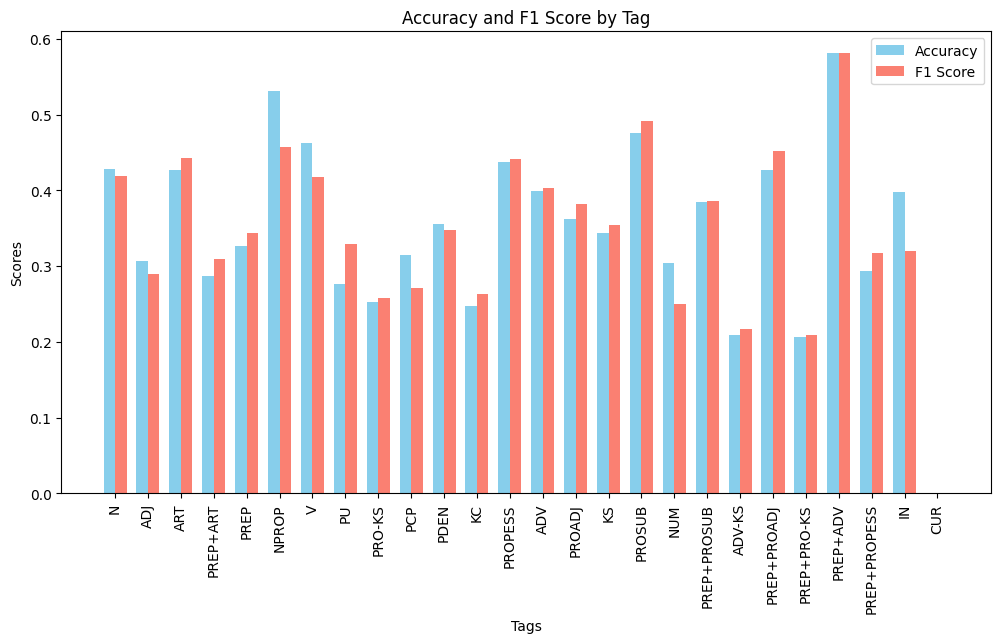

In [17]:
from collections import defaultdict
import matplotlib.pyplot as plt

# Dicionários para contagem
correct_counts = defaultdict(int)
total_counts = defaultdict(int)
true_positives = defaultdict(int)
false_positives = defaultdict(int)
false_negatives = defaultdict(int)

# Calcular contagens
for pred, true in zip(predicted_tags, true_tags):
    for p, t in zip(pred, true):
        total_counts[t] += 1
        if p == t:
            correct_counts[t] += 1
            true_positives[t] += 1
        else:
            false_positives[p] += 1
            false_negatives[t] += 1

# Preparar dados para o gráfico
tags, accuracies, f1_scores = [], [], []
for tag, total in total_counts.items():
    accuracy = correct_counts[tag] / total if total > 0 else 0
    precision = true_positives[tag] / (true_positives[tag] + false_positives[tag]) if true_positives[tag] + false_positives[tag] > 0 else 0
    recall = true_positives[tag] / total if total > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

    tags.append(tag)
    accuracies.append(accuracy)
    f1_scores.append(f1)

# Gerar o gráfico de barras para acurácia e F1 score
fig, ax = plt.subplots(figsize=(12, 6))
width = 0.35
indices = range(len(tags))

ax.bar([i - width/2 for i in indices], accuracies, width, label='Accuracy', color='skyblue')
ax.bar([i + width/2 for i in indices], f1_scores, width, label='F1 Score', color='salmon')

ax.set_xlabel('Tags')
ax.set_ylabel('Scores')
ax.set_title('Accuracy and F1 Score by Tag')
ax.set_xticks(indices)
ax.set_xticklabels(tags, rotation=90)
ax.legend()

plt.show()
